<font size = 7>DELE ST1504 CA2 Part A: Generative Adversarial Network </font>
<hr>
<font size = 4>
Name: Lee Hong Yi & Yadanar Aung<br>
Admin No: 2223010 & 2214621<br>
Class: DAAA/FT/2B/07<br>
</font>
<hr>

**Objective:**  
Develop a <u>Generative Adversarial Network (GAN) model</u> for <u>image generation</u>, utilizing the <u>CIFAR10 dataset</u>. The model aims to generate <u>1000 high-quality, small color images</u> in <u>10 distinct classes</u>, showcasing its ability to learn and replicate complex visual patterns.

**Background:**  
GANs are a revolutionary class of artificial neural networks used in unsupervised machine learning tasks. They consist of two parts: a Generator, which creates images, and a Discriminator, which evaluates them. The objective is to train a GAN that excels in producing diverse, realistic images that closely mimic the characteristics of the CIFAR10 dataset.

**Key Features:** <br>
Implement and evaluate different GAN architectures to determine the most effective model for the CIFAR10 specific image generation task, which should generate images that not only are visually appealing and realistic but also display a wide range of creativity within the constraints of the 10 classes in the dataset.

**Output Specification:**  
The model will produce images that are evaluated based on their similarity to the real images in the CIFAR10 dataset and their diversity across the dataset's classes. The performance of the GAN will be a crucial indicator of its effectiveness in learning and replicating complex patterns from a given dataset.

<hr>
<font size = 5>Performing initial set-up</font>
<hr>

In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, Dropout, Flatten, Input, Activation, GlobalMaxPooling2D, Conv2DTranspose, PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.initializers import RandomNormal
from tensorflow_addons.layers import SpectralNormalization

import GAN_function as gnnf

In [122]:
# Check GPU is available
gpus = tf.config.experimental.list_physical_devices('GPU')

# Memory control: Prevent tensorflow from allocating totality of GPU memory
for gpu in gpus:
    try:
        print(tf.config.experimental.get_device_details(gpu))
    except:
        pass
    tf.config.experimental.set_memory_growth(gpu, True)
print(f"There are {len(gpus)} GPU(s) present.")

{'device_name': 'NVIDIA GeForce RTX 3060', 'compute_capability': (8, 6)}
There are 1 GPU(s) present.


In [123]:
from warnings import simplefilter
simplefilter(action='ignore', category=UserWarning)     
simplefilter(action='ignore', category=FutureWarning) 

In [124]:
# Fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(0)  

<hr>
<font size = 5>Background Research</font>
<hr>

**CIFAR10 Dataset:**  
- The CIFAR10 dataset consists of <u>60,000 colour images</u> in <u>10 classes</u>. 
- There are 6,000 images per class.

**Images:**  
- The images are split into 50,000 train images and 10,000 test images.
- The images are of <u>size 32x32</u>.

**Classes:**  
- Total of 10 distinct classes:
    1. airplane
    2. automoblie
    3. bird
    4. cat
    5. deer
    6. dog
    7. frog
    8. horse
    9. ship
    10. truck
- Classes are mutually exclusive. 
    - There is no overlap between automobiles and trucks, neither includes pickup trucks.
    - "Automobile" includes sedans, SUVs, etc. 
    - "Truck" includes only big trucks.

**Batches:**  
- The dataset is divided into 5 train batches & 1 test batch, each with 10,000 images.
- Train batches contain 50,000 images in total from each class in random order
    - Some batches contain more images from one class than another
- Test batch contains 10,000 randomly-selected images from each class

**Source:**
https://www.cs.toronto.edu/~kriz/cifar.html

<font size = 5>Load CIFAR10 Dataset</font>

Returns two tuples, each containing two elements. <br>
The first element of each tuple is an array of images.<br>
The second element is an array of corresponding labels.

In [125]:
# Load CIFAR10 Dataset
cifar10 = tf.keras.datasets.cifar10.load_data()

In [126]:
# Split into train & test
(X_train, _), (_, _) = cifar10

print(f"Shape of data: {X_train.shape}")
X_train = X_train / 127.5 - 1.


Shape of data: (50000, 32, 32, 3)


<font size = 5>Class Labels</font>

In [127]:
# Map integer class labels to their corresponding class names 
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

<hr>
<font size = 5>Exploratory Data Analysis (EDA)</font>
<hr>

### Exploratory Data Analysis (EDA) Tips
1. *Visualize Images*: Display a sample of images from each of the 10 classes to understand the variety and quality of images in the dataset.
2. *Class Distribution*: Check if the dataset is balanced across different classes.
3. *Pixel Distribution*: Analyze the distribution of pixel values across the entire dataset and within each class to understand the color distribution.
4. *Image Size and Resolution Analysis*: CIFAR-10 images are 32x32, but it's good to visualize and understand this small resolution's impact.
5. *Correlation Analysis*: Assess if there are any interesting correlations between different color channels.
6. *Data Augmentation Impact*: Visualize how different data augmentation techniques (like rotation, flipping, scaling) affect the images.

<font size = 5>Data Visualization</font>

<font size = 5>Class Distribution</font>

<hr>
<font size = 5>Feature Engineering</font>
<hr>

### Feature Engineering
1. *Normalization*: Scale pixel values to a range (e.g., 0 to 1 or -1 to 1) to help the model train more efficiently.
2. *Color Space Conversion*: Experiment with different color spaces (like HSV or grayscale) to see if they impact the GAN's performance.
3. *Edge Detection*: Implement edge detection (like the Sobel filter) to create features that emphasize shapes and borders in images.
4. *Noise Addition*: For robustness, you can add small amounts of noise to the input images.
5. *Data Augmentation*: Use techniques like flipping, cropping, or rotating to artificially expand the training dataset.
6. *Dimensionality Reduction*: Experiment with techniques like PCA to reduce the number of input features while retaining essential information.

<hr>
<font size = 5>Initial Modelling</font>
<hr>

Potential Models:
1. DCGAN
2. cGAN
3. SAGAN

Early Stopping to identify when the model collapses

In [128]:
class GAN_template():
    def __init__(self, rows, cols, channels, z = 10):
        self.d_losses = []
        self.d_accuracies = []
        self.g_losses = []
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=Adam(0.00005, 0.5),
            metrics=['accuracy'])

        # Build the generator

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        noise_shape = (self.latent_dim,)
        weights_init = RandomNormal(mean=0, stddev=0.02)

        model = Sequential(name='generator_GAN')
        model.add(Dense(8*8*512, input_shape=noise_shape, kernel_initializer=weights_init))
        model.add(Reshape((8, 8, 512)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size = 3, padding = "same", activation = "relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())

        model.add(Conv2D(64, kernel_size = 3, padding = "same", activation = "relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size = 3, padding = "same", activation = "relu"))
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential(name='discriminator_GAN')

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=256, save_interval=50):


        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            if epoch % 5 == 0:
                d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            self.d_losses.append(d_loss[0])
            self.d_accuracies.append(100 * d_loss[1])
            self.g_losses.append(g_loss)

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, epochs)


    def save_imgs(self, epoch, epoch_lim):
        # Assuming self.latent_dim and self.generator are defined elsewhere in your class
        r, c = 3, 6  # 3 rows and 5 columns for images
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        # Define the figure and GridSpec with a custom layout
        fig = plt.figure(figsize=(15, 10))  # Width, Height (adjust as necessary)
        gs = fig.add_gridspec(4, 6, height_ratios=[0.8, 0.8, 0.8, 1], width_ratios=[1, 1, 1, 1, 1, 1], hspace=0.15, wspace=0.3)
        plt.tight_layout()

        # Plot the generated images in the first 3 rows
        for i in range(r):
            for j in range(c):
                ax = fig.add_subplot(gs[i, j])
                gen_imgs = np.clip(gen_imgs, 0, 1)
                ax.imshow(gen_imgs[i * c + j])
                ax.axis('off')

        # Plot the line graphs in the fourth row
        ax_loss = fig.add_subplot(gs[3, 0:2])  # Span the first two columns for the first graph
        ax_loss.plot(self.d_losses, label="Discriminator Loss")
        ax_loss.set_title("Discriminator Loss")
        ax_loss.set_xlim(0,epoch_lim)

        ax_g_loss = fig.add_subplot(gs[3, 2:4])  # Span the next two columns for the second graph
        ax_g_loss.plot(self.g_losses, label="Generator Loss")
        ax_g_loss.set_title("Generator Loss")
        ax_g_loss.set_xlim(0,epoch_lim)

        # The last plot for discriminator accuracy might span only one column or two depending on your layout preference
        ax_acc = fig.add_subplot(gs[3, 4:6])  # This one only spans the last column
        ax_acc.plot(self.d_accuracies, label="Discriminator Accuracy")
        ax_acc.set_title("Discriminator Accuracy")
        ax_acc.set_xlim(0,epoch_lim)

        # Add a super title and adjust layout
        fig.suptitle(f"Epoch {epoch}", y = 0.92)
        # Save the figure
        fig.savefig(f"./output/dcgan_mnist_{epoch}.png", bbox_inches='tight')
        plt.close(fig)


Model: "generator_GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 32768)             360448    
                                                                 
 reshape_15 (Reshape)        (None, 8, 8, 512)         0         
                                                                 
 up_sampling2d_24 (UpSamplin  (None, 16, 16, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_106 (Conv2D)         (None, 16, 16, 128)       589952    
                                                                 
 batch_normalization_69 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                                 
 up_sampling2d_25 (UpSamplin  (None, 32, 32, 128)    

Model: "discriminator_GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_109 (Conv2D)         (None, 16, 16, 32)        896       
                                                                 
 leaky_re_lu_72 (LeakyReLU)  (None, 16, 16, 32)        0         
                                                                 
 dropout_24 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_110 (Conv2D)         (None, 8, 8, 64)          18496     
                                                                 
 zero_padding2d_12 (ZeroPadd  (None, 9, 9, 64)         0         
 ing2D)                                                          
                                                                 
 batch_normalization_71 (Bat  (None, 9, 9, 64)         256       
 chNormalization)                                

KeyboardInterrupt: 

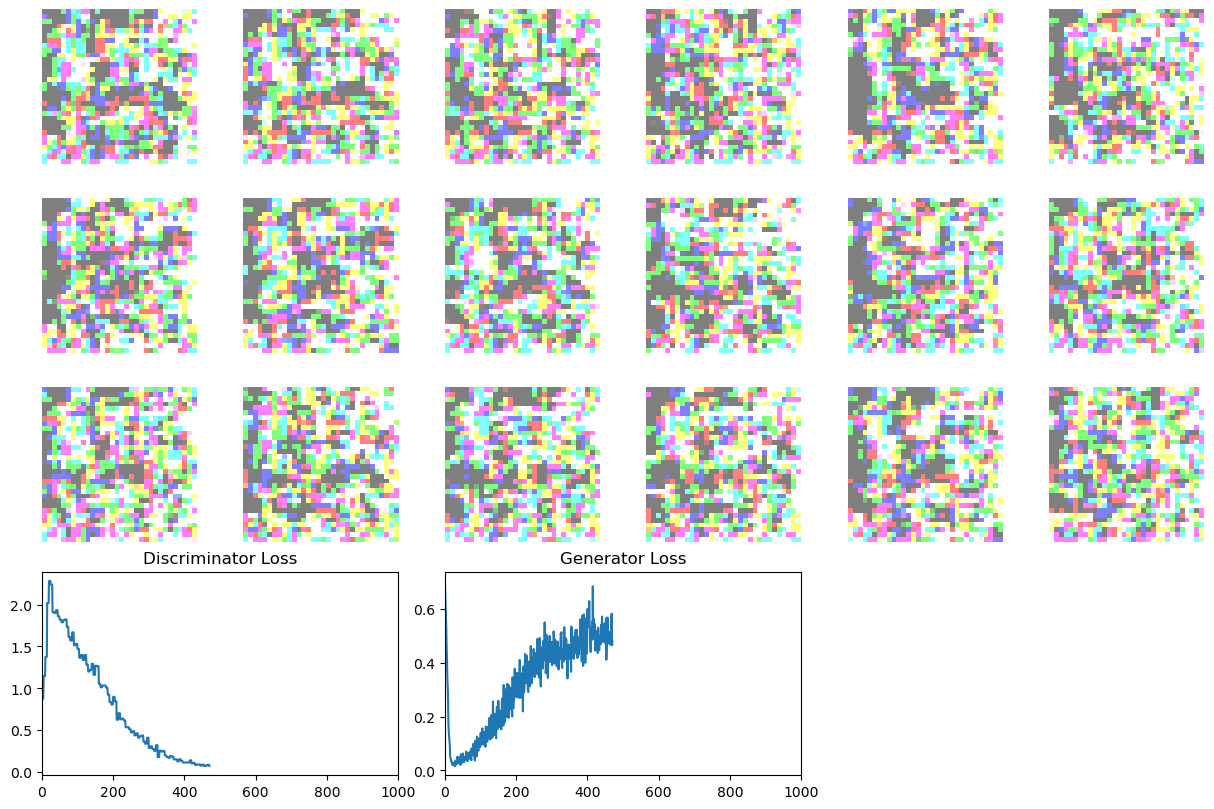

In [129]:
dcgan = GAN_template(32,32,3)
dcgan.train(epochs=1000, batch_size=128, save_interval=10)

In [ ]:
input_folder = './output'  # Replace with your frames directory
output_file = 'output_video.mp4'      # Replace with your desired output file path
gnnf.create_video_from_frames(input_folder, output_file)

<hr>
<font size = 5>Model Improvement</font>
<hr>

### Miscellaneous
- *Hyperparameter Tuning*: Experiment with different architectures and training parameters.
- *Loss Function Analysis*: Explore various loss functions and their impact on the generated images' quality

### Advanced Techniques
1. *Feature Learning with Autoencoders*: Use autoencoders to learn compressed representations of the images, which might help in generating new images.
2. *Generative Feature Extraction*: Experiment with using features extracted from other pretrained models as inputs to your GAN.

<hr>
<font size = 5>Result Evaluation</font>
<hr>

### Evaluation Metrics
- *FID Score*: Use the Fréchet Inception Distance to evaluate the quality of images generated by your GAN.
- *Visual Inspection*: Regularly sample and inspect generated images to qualitatively assess the model's performance.